<a href="https://colab.research.google.com/github/justeaguey/CE888/blob/main/Assignment%202/CE888_Jupyter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
import tensorflow as tf
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet121
from keras import callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/CE888/Test.zip"
!unzip "/content/gdrive/My Drive/CE888/Training.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Training/No_Fire/lake_resized_lake_frame1670.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1674.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1675.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1695.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1718.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1734.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1753.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1788.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1793.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1799.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1802.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1811.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1817.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1829.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame

In [ ]:
#parameters for our model
batch_size = 32
epochs = 25
image_size = 254

In [ ]:
#data generator to feed through batches of training images, with a 20% validation split and image augmentation
training_datagenerator = ImageDataGenerator(rescale = 1./255,
    validation_split = 0.2,
    brightness_range = [0.6, 0.8])

#data generator to feed through batches of test images
test_datagenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
#iterators to feed our model with the images
train_iterator = training_datagenerator.flow_from_directory("Training", class_mode='binary', target_size=(image_size, image_size), batch_size = batch_size, shuffle=True, subset = 'training')

validation_iterator = training_datagenerator.flow_from_directory("Training", class_mode='binary', target_size=(image_size, image_size), batch_size = batch_size, shuffle=True, subset = 'validation')

test_iterator = test_datagenerator.flow_from_directory("Test", class_mode='binary', target_size=(image_size, image_size), batch_size = batch_size, shuffle=False)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
#load the Xception model
XceptionModel = tf.keras.applications.Xception(input_shape=(image_size,image_size,3), include_top = False, weights = "imagenet")

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
#allow parameters in the model to be trainable
XceptionModel.trainable = True

In [ ]:
#add custom output layers to the model
transfer_model = tf.keras.Sequential([XceptionModel,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(1, activation="sigmoid")                                     
                                ])

In [ ]:
#compile the model with an adam optimiser
optim = Adam(lr = 0.00005)
transfer_model.compile(optimizer = optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#monitors the validation loss value and will stop training when there is an increase
earlystop = callbacks.EarlyStopping(monitor = "val_loss", 
                                        mode = "min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
#train the model
transfer_outputs = transfer_model.fit(train_iterator, 
                    epochs = epochs, steps_per_epoch = 100,
                    validation_data = validation_iterator,
                    validation_steps = 20,
                    #callbacks = [earlystop], #stops the function before it starts to over fit
                    class_weight = {0: 0.73, 1: 1.27}) #encourages model to pay more attention to the 'No-Fire' class by weighting its loss higher

Epoch 1/25
100/100 [==============================] - 173s 2s/step - loss: 0.0897 - accuracy: 0.9799 - val_loss: 0.0860 - val_accuracy: 0.9625
Epoch 2/25
100/100 [==============================] - 168s 2s/step - loss: 0.0210 - accuracy: 0.9962 - val_loss: 0.1451 - val_accuracy: 0.9578
Epoch 3/25
100/100 [==============================] - 169s 2s/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.1298 - val_accuracy: 0.9688
Epoch 4/25
100/100 [==============================] - 169s 2s/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.1713 - val_accuracy: 0.9609
Epoch 5/25
100/100 [==============================] - 169s 2s/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.1469 - val_accuracy: 0.9594
Epoch 6/25
100/100 [==============================] - 170s 2s/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.1190 - val_accuracy: 0.9719
Epoch 7/25
100/100 [==============================] - 169s 2s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1746 - val_accuracy: 0.9547

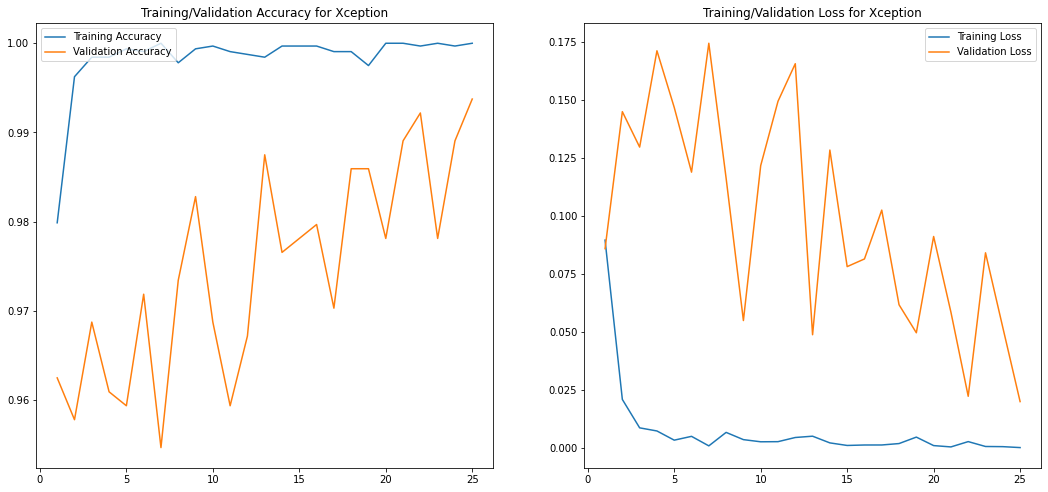

In [ ]:
#plot accuracy and loss for each epoch
transfer_accuracy = transfer_outputs.history['accuracy']
transfer_validation_accuarcy = transfer_outputs.history['val_accuracy']
transfer_loss = transfer_outputs.history['loss']
transfer_validation_loss = transfer_outputs.history['val_loss']

epochs_len = len(transfer_outputs.history['loss']) #displays number of runs the model trained for before stopping

plt.figure(figsize=(18, 18))
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs_len + 1), transfer_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs_len + 1), transfer_validation_accuarcy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training/Validation Accuracy for Xception')

plt.subplot(2, 2, 2)
plt.plot(range(1, epochs_len + 1), transfer_loss, label='Training Loss')
plt.plot(range(1, epochs_len + 1), transfer_validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training/Validation Loss for Xception')
plt.show()

In [ ]:
#reset the test iterator before evaluation
test_iterator.reset()

In [ ]:
#calculate loss and accuracy of the model on the test set
transfer_test_loss, transfer_test_accuarcy = transfer_model.evaluate(test_iterator, steps = test_iterator.samples//batch_size)

269/269 [==============================] - 96s 357ms/step - loss: 0.6479 - accuracy: 0.7713


In [ ]:
transfer_test_loss

0.6479473114013672

In [ ]:
transfer_test_accuarcy

0.7712593078613281

In [ ]:
#reset the test iterator before predictions
test_iterator.reset()

In [ ]:
#perform predictions on the test set with the trained model
probabilities = transfer_model.predict(test_iterator)

In [ ]:
#convert the predictions into the binary class values
predicted_class_indices = np.where(probabilities > 0.5, 1, 0)

In [ ]:
#true labels of the test set
labels=(test_iterator.classes)

In [ ]:
print(classification_report(labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.94      0.66      0.78      5137
           1       0.65      0.93      0.77      3480

    accuracy                           0.77      8617
   macro avg       0.79      0.80      0.77      8617
weighted avg       0.82      0.77      0.77      8617



In [ ]:
conf_matrix = confusion_matrix(labels, predicted_class_indices)
conf_matrix

array([[3404, 1733],
       [ 236, 3244]])

Text(0.5, 1.0, 'Confusion Matrix')

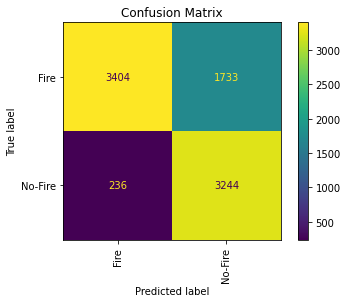

In [ ]:
confdisplay = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Fire','No-Fire'])
confdisplay = confdisplay.plot(xticks_rotation = 90, values_format = '.0f')
confdisplay.ax_.set_title('Confusion Matrix')

In [ ]:
#reset iterators for DenseNet training
train_iterator.reset()
validation_iterator.reset()

In [ ]:
#load the DenseNet model
DenseNetModel = tf.keras.applications.DenseNet121(input_shape=(image_size,image_size,3), include_top = False)

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
#allow parameters in the model to be trainable
DenseNetModel.trainable = True

In [ ]:
#add custom output layers to the model
transfer_model2 = tf.keras.Sequential([DenseNetModel,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(1, activation="sigmoid")                                     
                                ])

In [ ]:
#compile the model with an adam optimiser
optim = Adam(lr = 0.00005)
transfer_model2.compile(optimizer = optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#train the model
transfer_outputs2 = transfer_model2.fit(train_iterator, 
                    epochs = epochs, steps_per_epoch = 100,
                    validation_data = validation_iterator,
                    validation_steps = 20,
                    #callbacks = [earlystop], #stops the function before it starts to over fit
                    class_weight = {0: 0.73, 1: 1.27}) #encourages model to pay more attention to the 'No-Fire' class by weighting its loss higher

Epoch 1/25
100/100 [==============================] - 116s 985ms/step - loss: 0.2200 - accuracy: 0.8856 - val_loss: 0.1626 - val_accuracy: 0.9484
Epoch 2/25
100/100 [==============================] - 96s 960ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.2770 - val_accuracy: 0.9484
Epoch 3/25
100/100 [==============================] - 97s 966ms/step - loss: 0.0118 - accuracy: 0.9977 - val_loss: 0.0880 - val_accuracy: 0.9578
Epoch 4/25
100/100 [==============================] - 97s 968ms/step - loss: 0.0097 - accuracy: 0.9968 - val_loss: 0.1809 - val_accuracy: 0.9609
Epoch 5/25
100/100 [==============================] - 96s 964ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.2260 - val_accuracy: 0.9500
Epoch 6/25
100/100 [==============================] - 96s 963ms/step - loss: 0.0039 - accuracy: 0.9981 - val_loss: 0.1158 - val_accuracy: 0.9625
Epoch 7/25
100/100 [==============================] - 100s 998ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1260 - val_

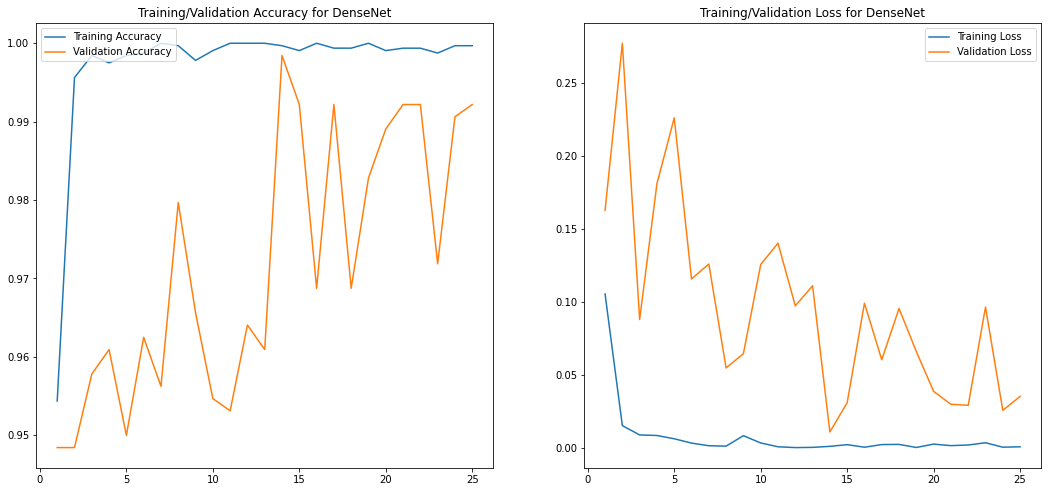

In [ ]:
#plot accuracy and loss for each epoch
transfer_accuracy = transfer_outputs2.history['accuracy']
transfer_validation_accuarcy = transfer_outputs2.history['val_accuracy']
transfer_loss = transfer_outputs2.history['loss']
transfer_validation_loss = transfer_outputs2.history['val_loss']

epochs_len = len(transfer_outputs2.history['loss']) #displays number of runs the model trained for before stopping

plt.figure(figsize=(18, 18))
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs_len + 1), transfer_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs_len + 1), transfer_validation_accuarcy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training/Validation Accuracy for DenseNet')

plt.subplot(2, 2, 2)
plt.plot(range(1, epochs_len + 1), transfer_loss, label='Training Loss')
plt.plot(range(1, epochs_len + 1), transfer_validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training/Validation Loss for DenseNet')
plt.show()

In [ ]:
#reset the test iterator before evaluation
test_iterator.reset()

In [ ]:
#calculate loss and accuracy of the model on the test set
transfer_test_loss, transfer_test_accuarcy = transfer_model2.evaluate(test_iterator, steps = test_iterator.samples//batch_size)

269/269 [==============================] - 71s 265ms/step - loss: 0.4092 - accuracy: 0.8309


In [ ]:
transfer_test_loss

0.40918657183647156

In [ ]:
transfer_test_accuarcy

0.8308550119400024

In [ ]:
#reset the test iterator before predictions
test_iterator.reset()

In [ ]:
#perform predictions on the test set with the trained model
probabilities2 = transfer_model2.predict(test_iterator)

In [ ]:
#convert the predictions into the binary class values
predicted_class_indices2 = np.where(probabilities2 > 0.5, 1, 0)

In [ ]:
print(classification_report(labels, predicted_class_indices2))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      5137
           1       0.72      0.94      0.82      3480

    accuracy                           0.83      8617
   macro avg       0.84      0.85      0.83      8617
weighted avg       0.86      0.83      0.83      8617



In [ ]:
conf_matrix2 = confusion_matrix(labels, predicted_class_indices2)
conf_matrix2

array([[3881, 1256],
       [ 200, 3280]])

Text(0.5, 1.0, 'Confusion Matrix')

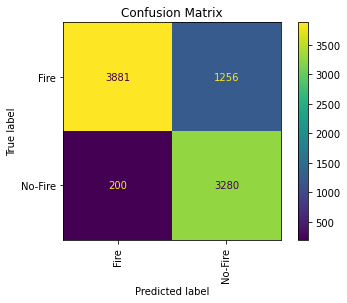

In [ ]:
confdisplay2 = ConfusionMatrixDisplay(confusion_matrix = conf_matrix2, display_labels=['Fire','No-Fire'])
confdisplay2 = confdisplay2.plot(xticks_rotation = 90, values_format = '.0f')
confdisplay2.ax_.set_title('Confusion Matrix')